## Note to reader

I will first manually test a few models for each case, then use a package that is used to compare models under different conditions. The size of the dataset here is ideal for something like this. 
My conclusion will be based on a couple of different factors:

- Explainability 
- Data Characteristics
- Model speed
- Metrics

The first few models are considered very simple models that can be used - while the section with Lazy Predict compares all possible classification models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.dtypes

x1    float64
x2    float64
x3    float64
x4    float64
y       int64
dtype: object

In [4]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

def get_result(true, predicted, model):
    cm = confusion_matrix(true, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    report = classification_report(true, predicted)
    disp.plot()
    print(report)


# Task: Train and test with class labels 2 and 3

In [5]:
filtered_data = data.query('y != 1')

## 1. Use all 50 samples, i.e., instances both for training and testing for each class (Logistic Regression classifier)

In [6]:
# making sure there are 50 samples for both classes 2 and 3
filtered_data['y'].value_counts()

2    50
3    50
Name: y, dtype: int64

In [7]:
filtered_data

,x1,x2,x3,x4,y
50,7.0,3.2,4.7,1.4,2
51,6.4,3.2,4.5,1.5,2
52,6.9,3.1,4.9,1.5,2
53,5.5,2.3,4.0,1.3,2
54,6.5,2.8,4.6,1.5,2
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,3
146,6.3,2.5,5.0,1.9,3
147,6.5,3.0,5.2,2.0,3
148,6.2,3.4,5.4,2.3,3


In [8]:
# In this case, we'll be using this single set to train and test

x_train = filtered_data[['x1','x2','x3','x4']]
y_train = filtered_data['y'].ravel()

In [9]:
from sklearn.linear_model import LogisticRegressionCV

model1 = LogisticRegressionCV(fit_intercept=True, cv=3, scoring='f1')
model1.fit(x_train, y_train)

# predict
y_pred1 = model1.predict(x_train)

              precision    recall  f1-score   support

           2       0.98      0.96      0.97        50
           3       0.96      0.98      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



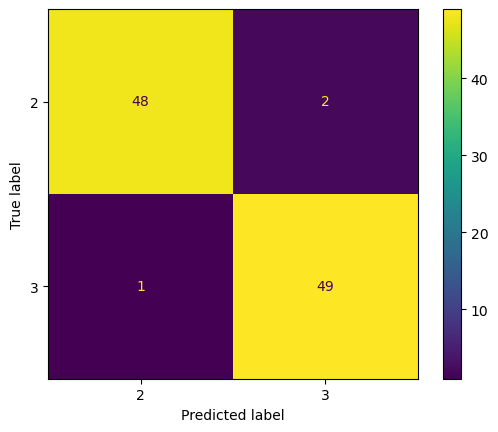

In [10]:
get_result(y_train, y_pred1, model1)

## 2. Use the first 40 samples, i.e., the instances for training and the rest of the 10 samples, i.e., instances for testing from each class.

In [11]:
# need to use sampling; need to figure out a way to do this

#def sample_group(group, n):
#    return group.sample(n, random_state=16)

#x_train = filtered_data.groupby('y', group_keys=False).apply(lambda group: sample_group(group, 40))

In [12]:
# going to have to split them manually

class_2 = filtered_data.query('y == 2')
class_2X = class_2.drop('y', axis=1)
class_2Y = class_2['y']
class_3 = filtered_data.query('y == 3')
class_3X = class_3.drop('y', axis=1)
class_3Y = class_3['y']

trainX_class2, testX_class2, trainY_class2, testY_class2 = class_2X[0:40], class_2X[40:], class_2Y[0:40], class_2Y[40:]
trainX_class3, testX_class3, trainY_class3, testY_class3 = class_3X[0:40], class_3X[40:], class_3Y[0:40], class_3Y[40:]

X_train = pd.concat([trainX_class2, trainX_class3], axis=0)
Y_train = pd.concat([trainY_class2, trainY_class3], axis=0)
X_test = pd.concat([testX_class2, testX_class3], axis=0)
Y_test = pd.concat([testY_class2, testY_class3], axis=0)

In [13]:
# check shape
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(80, 4) (80,) (20, 4) (20,)


In [14]:
# apply logistic regession again

model2 = LogisticRegressionCV(fit_intercept=True, cv=3, scoring='f1')
model2.fit(X_train, Y_train)

# predict
Y_pred2 = model2.predict(X_test)

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



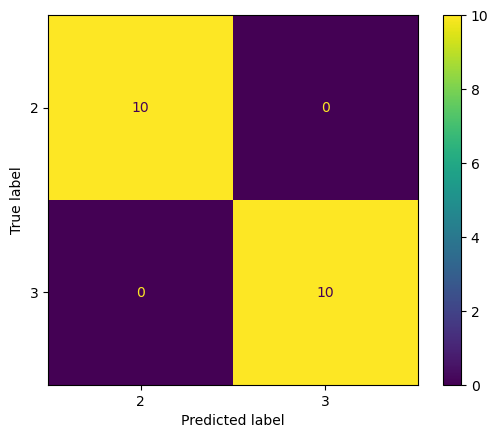

In [15]:
get_result(Y_test, Y_pred2, model2)

## 3. For each case, find the best classifier using all 4 feature sets and compare your findings using F1 scores derived from validation and test confusion matrices.

I will repeat each of the above cases (1 and 2) for each classifier. So basically, each classifier will have 2 cases. One with 50 samples, and another with 80 samples per class. 

Note: This is easily done with Lazy Predict, this should save me a lot of time.

In [16]:
# I'll need a function for this so streamline this process

def sample_dataset(condition, dataset):
    if condition == 'all':
        filtered_data = dataset.query('y != 1')
        X_train = filtered_data[['x1','x2','x3','x4']]
        Y_train = filtered_data['y'].ravel()
        return X_train, Y_train
    
    elif condition == 'sequential pareto':
        filtered_data = dataset.query('y != 1')
        class_2 = filtered_data.query('y == 2')
        class_2X = class_2.drop('y', axis=1)
        class_2Y = class_2['y']
        class_3 = filtered_data.query('y == 3')
        class_3X = class_3.drop('y', axis=1)
        class_3Y = class_3['y']

        trainX_class2, testX_class2, trainY_class2, testY_class2 = class_2X[0:40], class_2X[40:], class_2Y[0:40], class_2Y[40:]
        trainX_class3, testX_class3, trainY_class3, testY_class3 = class_3X[0:40], class_3X[40:], class_3Y[0:40], class_3Y[40:]

        X_train = pd.concat([trainX_class2, trainX_class3], axis=0)
        Y_train = pd.concat([trainY_class2, trainY_class3], axis=0)
        X_test = pd.concat([testX_class2, testX_class3], axis=0)
        Y_test = pd.concat([testY_class2, testY_class3], axis=0)

        return X_train, Y_train, X_test, Y_test

Since I've already covered logistic regression, so I will try another model. From here on, each model I test will be logged with two cases. Should make reading a bit easier.

### Model: Naive Bayes

#### Case 1: All samples

              precision    recall  f1-score   support

           2       0.94      0.94      0.94        50
           3       0.94      0.94      0.94        50

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100



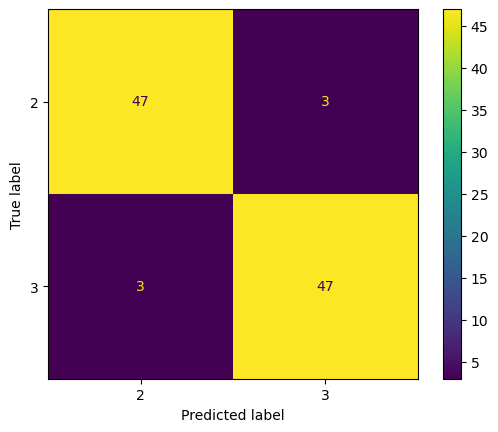

In [17]:
from sklearn.naive_bayes import GaussianNB

X_train, Y_train = sample_dataset('all', data)

# Fit
model3 = GaussianNB()
model3.fit(X_train, Y_train)

# Predict
Y_pred3 = model3.predict(X_train)

get_result(Y_train, Y_pred3, model3)

#### Case 2: Sequential sampling

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



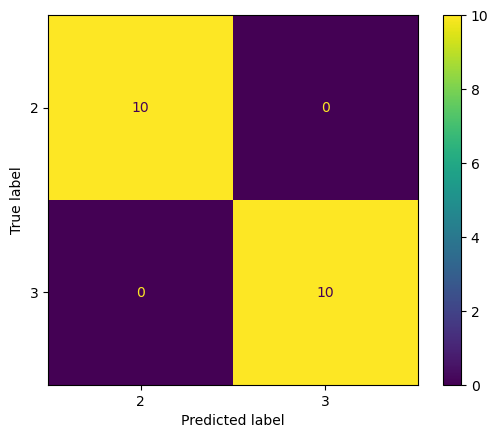

In [18]:
X_train, Y_train, X_test, Y_test = sample_dataset('sequential pareto', data)

# fit
model4 = GaussianNB()
model4.fit(X_train, Y_train)

# predict
Y_pred4 = model4.predict(X_test)

get_result(Y_test, Y_pred4, model4)

### Model: Decision Trees

#### Case 1: All samples

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



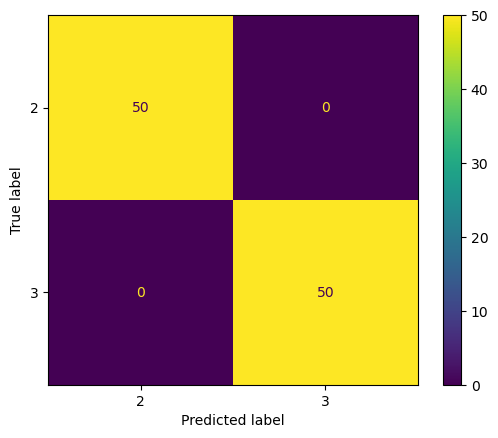

In [19]:
from sklearn.tree import DecisionTreeClassifier

X_train, Y_train = sample_dataset('all', data)

model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train)

get_result(Y_train, Y_pred, model)

#### Case 2: Sequential sampling

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



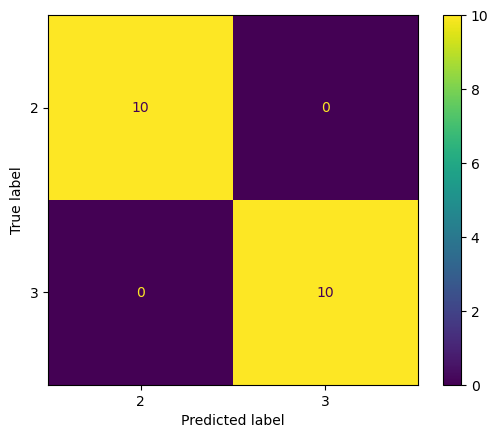

In [20]:
X_train, Y_train, X_test, Y_test = sample_dataset('sequential pareto', data)

# fit
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)

# predict
Y_pred = model.predict(X_test)

get_result(Y_test, Y_pred4, model)

### Model: Random Forests

#### Case 1: All samples

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



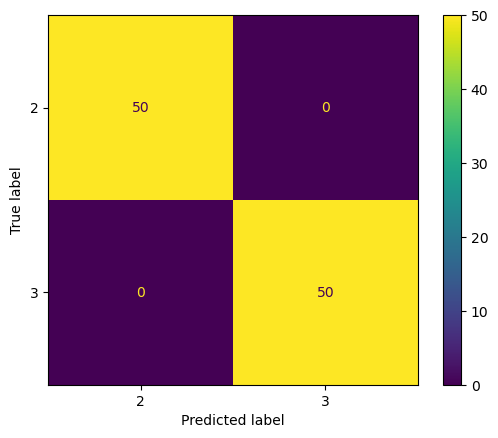

In [21]:
from sklearn.ensemble import RandomForestClassifier

X_train, Y_train = sample_dataset('all', data)

model = RandomForestClassifier()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train)

get_result(Y_train, Y_pred, model)

#### Case 2: Sequential sampling

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



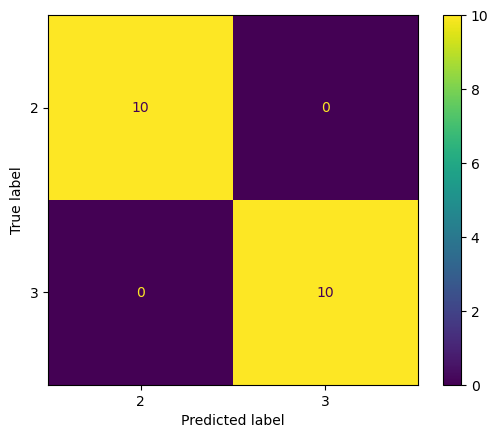

In [22]:
X_train, Y_train, X_test, Y_test = sample_dataset('sequential pareto', data)

# fit
model = RandomForestClassifier()
model.fit(X_train, Y_train)

# predict
Y_pred = model.predict(X_test)

get_result(Y_test, Y_pred, model)

### Model: Random Forest (Completely Randomized Trees / Extra Trees)

#### Case 1: All samples

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



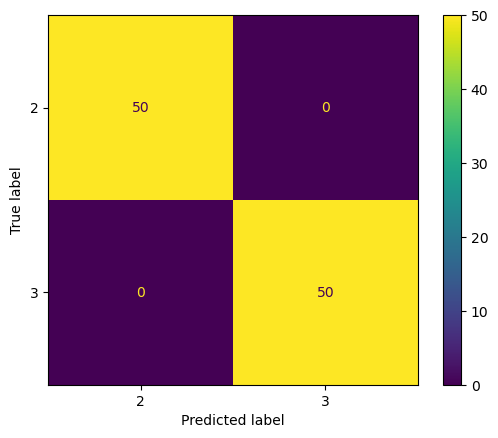

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

X_train, Y_train = sample_dataset('all', data)

model = ExtraTreesClassifier()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train)

get_result(Y_train, Y_pred, model)

#### Case 2: Sequential Sampling

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



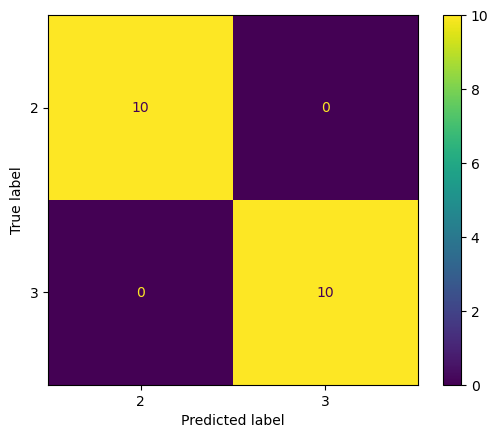

In [24]:
X_train, Y_train, X_test, Y_test = sample_dataset('sequential pareto', data)

# fit
model = ExtraTreesClassifier()
model.fit(X_train, Y_train)

# predict
Y_pred = model.predict(X_test)

get_result(Y_test, Y_pred, model)

### Model: Support Vector Machines

#### Case 1: All samples

              precision    recall  f1-score   support

           2       0.96      0.96      0.96        50
           3       0.96      0.96      0.96        50

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100



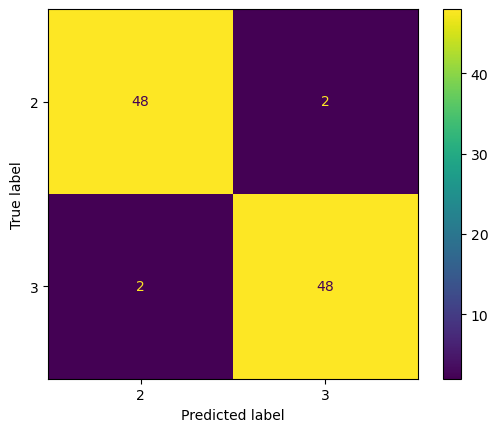

In [25]:
from sklearn.svm import SVC

X_train, Y_train = sample_dataset('all', data)

model = SVC()
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train)

get_result(Y_train, Y_pred, model)

#### Case 2: Sequential sampling

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



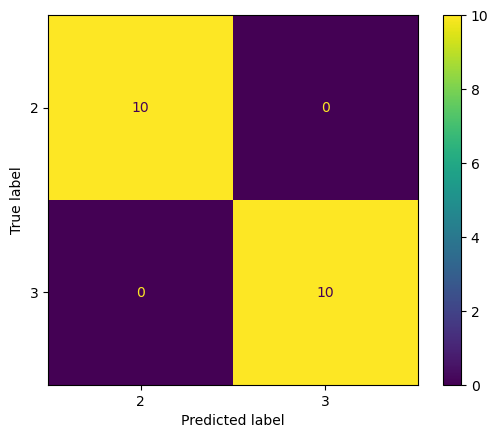

In [26]:
X_train, Y_train, X_test, Y_test = sample_dataset('sequential pareto', data)

# fit
model = SVC()
model.fit(X_train, Y_train)

# predict
Y_pred = model.predict(X_test)

get_result(Y_test, Y_pred, model)

## Lazy Predict

With Lazy Predict; Case 1

In [28]:
from lazypredict.Supervised import LazyClassifier

X_train, Y_train = sample_dataset('all', data)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_train, Y_train, Y_train)

 97%|█████████▋| 28/29 [00:01<00:00, 19.64it/s]d:\Anaconda\envs\MDL2\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Anaconda\envs\MDL2\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
100%|██████████| 29/29 [00:01<00:00, 15.41it/s]

[LightGBM] [Info] Number of positive: 50, number of negative: 50
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [29]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,1.00,1.00,1.00,1.00,0.23
ExtraTreesClassifier,1.00,1.00,1.00,1.00,0.09
RandomForestClassifier,1.00,1.00,1.00,1.00,0.11
BaggingClassifier,1.00,1.00,1.00,1.00,0.06
LabelSpreading,1.00,1.00,1.00,1.00,0.01
LabelPropagation,1.00,1.00,1.00,1.00,0.17
LGBMClassifier,1.00,1.00,1.00,1.00,0.27
ExtraTreeClassifier,1.00,1.00,1.00,1.00,0.01
DecisionTreeClassifier,1.00,1.00,1.00,1.00,0.01


With Lazy Predict; Case 2

In [31]:
X_train, Y_train, X_test, Y_test = sample_dataset('sequential pareto', data)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 29/29 [00:00<00:00, 52.91it/s]

[LightGBM] [Info] Number of positive: 40, number of negative: 40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

In [32]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LinearSVC,1.00,1.00,1.00,1.00,0.01
BaggingClassifier,1.00,1.00,1.00,1.00,0.06
SVC,1.00,1.00,1.00,1.00,0.01
SGDClassifier,1.00,1.00,1.00,1.00,0.01
RidgeClassifierCV,1.00,1.00,1.00,1.00,0.01
RidgeClassifier,1.00,1.00,1.00,1.00,0.01
RandomForestClassifier,1.00,1.00,1.00,1.00,0.11
QuadraticDiscriminantAnalysis,1.00,1.00,1.00,1.00,0.01
Perceptron,1.00,1.00,1.00,1.00,0.01


# Conclusions

For case 1 - given the small size of the dataset and the task; I think a DT classifier or Random Forest classifier would be a relatively quick and easy way to do things based on the given F1 and AUC scores.

For case 2 - more simpler models like a Linear SVM or even Logistic Regression will suffice because of their explainability and performance on the test set. The prior models in case 1 are also applicable here due to similar performance scores (not including time taken). 

*Note: Given the appearance of the confusion matrices before the Lazy Predict was applied; it is assumed that the matrices are more or less going to be similar for all models.*